# 2 Batch data analysis
>In this problem, we will look into batch data; dynamic time-series of a finite duration. Batch manufacturing processes are very common in chemical, pharma, bioengineering and semiconductor industries such as baker's yeast production, beer brewing and vaccines production.


>In theory, a reactor is designed with temperature, pressure, level, pH control and multiple sensors that measure these variables among others. A perfect batch (again in theory) is one that is tightly controlled to the specifications and as a result the productivity and quality of the final product is optimized.


>In real life, a typical batch is run from a few hours up to a week or two and a lot of things can go wrong during this period. There is always variability either because the process is very sensitive to minor 
fluctuations in some variables or the control of some variables failed
for a period of time.


>In a company that implements Data Analytics or Multivariate Statistical Process Control (MSPC) monitoring is typically implemented with the following steps:


> 1. Identify a number of reference, perfect **historical** batches (15-20), both in terms of high productivity/quality and minimum anomalies or fluctuations around the setpoints.


> 2. Create a PCA model of the perfect batches identified. This is your **model**.

> 3. Every time your site is running a new batch, **fit** your data **online** or as soon as your data infrastructure allows you to do so. Fitting will tell you whether your batch is similar to the perfect batches or it is deviating from the reference behaviour.


>Next, you will follow these steps to build a Batch Statistical Process Control and implement it to monitor a new batch (we will assume that you got the data at the end of the batch and t them to the model). The dataset is from a baker's yeast production facility in Solna, Sweden capturing the last step of the fermentation.

## 2.1 Build a Batch Statistical Process Control model
> 1. Import the data from 'bakers yeast reference batches.xlsx'. Identify how many batches are in the data. What is the duration of each batch and how many data points are there per batch? How many variables are measured (including time)?


There are 16 batches in the data: 'hb', 'kb', 'eb', 'Ta', 'cb', 'gb', 'jb', 'Va', 'lb', 'bb', 'ib', 'db', 'Ma', 'Na', 'fb', 'Xa'. 

The duration of each batch is 13.6667. There are 83 data points per batch. 


There are 8 variables measured: 'Time', 'Ethanol', 'Temperature', 'Molasses flow', 'NH3 flow', 'Air flow', 'Level', 'pH'.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

In [2]:
#Import the data from 'bakers yeast reference batches.xlsx'
bakers = pd.read_excel('bakers_yeast_reference_batches.xlsx')
bakers.head()

,Unnamed: 0,Primary ID,BatchID,Time,Ethanol,Temperature,Molasses flow,NH3 flow,Air flow,Level,pH
0,249,250,bb,0.000000,0.05059,31.9580,212.328,6.16453,1382.19,43.4194,5.85607
1,250,251,bb,0.166667,0.04930,31.5303,835.476,29.78270,2084.42,43.4853,5.34603
2,251,252,bb,0.333333,0.04973,30.8220,910.155,32.50710,2266.47,43.5628,5.18718
3,252,253,bb,0.500000,0.04915,30.1617,985.011,36.37100,2446.84,43.6002,5.18043
4,253,254,bb,0.666667,0.04744,29.8891,1052.450,39.26990,2636.96,43.6572,5.18145


In [3]:
#number of batchs
print(f"There are {len(bakers.BatchID.unique())} batches in the data. They are {bakers.BatchID.unique()}.")

There are 16 batches in the data. They are ['bb' 'cb' 'db' 'eb' 'fb' 'gb' 'hb' 'ib' 'jb' 'kb' 'lb' 'Ma' 'Na' 'Ta'
 'Va' 'Xa'].


In [4]:
#duration of each batch
print("The duration of each batch is: ")
print(bakers.groupby('BatchID').Time.max())

The duration of each batch is: 
BatchID
Ma    13.6667
Na    13.6667
Ta    13.6667
Va    13.6667
Xa    13.6667
bb    13.6667
cb    13.6667
db    13.6667
eb    13.6667
fb    13.6667
gb    13.6667
hb    13.6667
ib    13.6667
jb    13.6667
kb    13.6667
lb    13.6667
Name: Time, dtype: float64


In [5]:
#how many data points are there per batch
print("The number of points per batch is: ")
print(bakers.groupby('BatchID').Time.count())

The number of points per batch is: 
BatchID
Ma    83
Na    83
Ta    83
Va    83
Xa    83
bb    83
cb    83
db    83
eb    83
fb    83
gb    83
hb    83
ib    83
jb    83
kb    83
lb    83
Name: Time, dtype: int64


In [3]:
#How many variables are measured (including time)?
bakers = bakers.drop(['Unnamed: 0','Primary ID'], axis = 1)
bakers.set_index("BatchID", inplace=True)
print(f"There are {len(bakers.columns)} variables measured. They are {list(bakers.columns)}.")

There are 8 variables measured. They are ['Time', 'Ethanol', 'Temperature', 'Molasses flow', 'NH3 flow', 'Air flow', 'Level', 'pH'].


> 2. Plot the variables time-profiles in a 2x4 subplot. Inspect the graphs (don't just plot them). Look for potential outliers. Which variables have the largest variability? Which variables are tightly controlled?

From the variables time-profiles plot, we can identify some features have outliers in certain batches, such as "va" batch in "Air flow" since it fluctuates extremely.

 *Variable 'Ethanol' has the largest variabiltiy since for the time series for different batches are very fluctuating and almost no pattern could be found; variables 'Air flow' and 'PH' may have very low variability although there exists couple of outliers, the time series are overlapping with each other and pattern is consistent.*

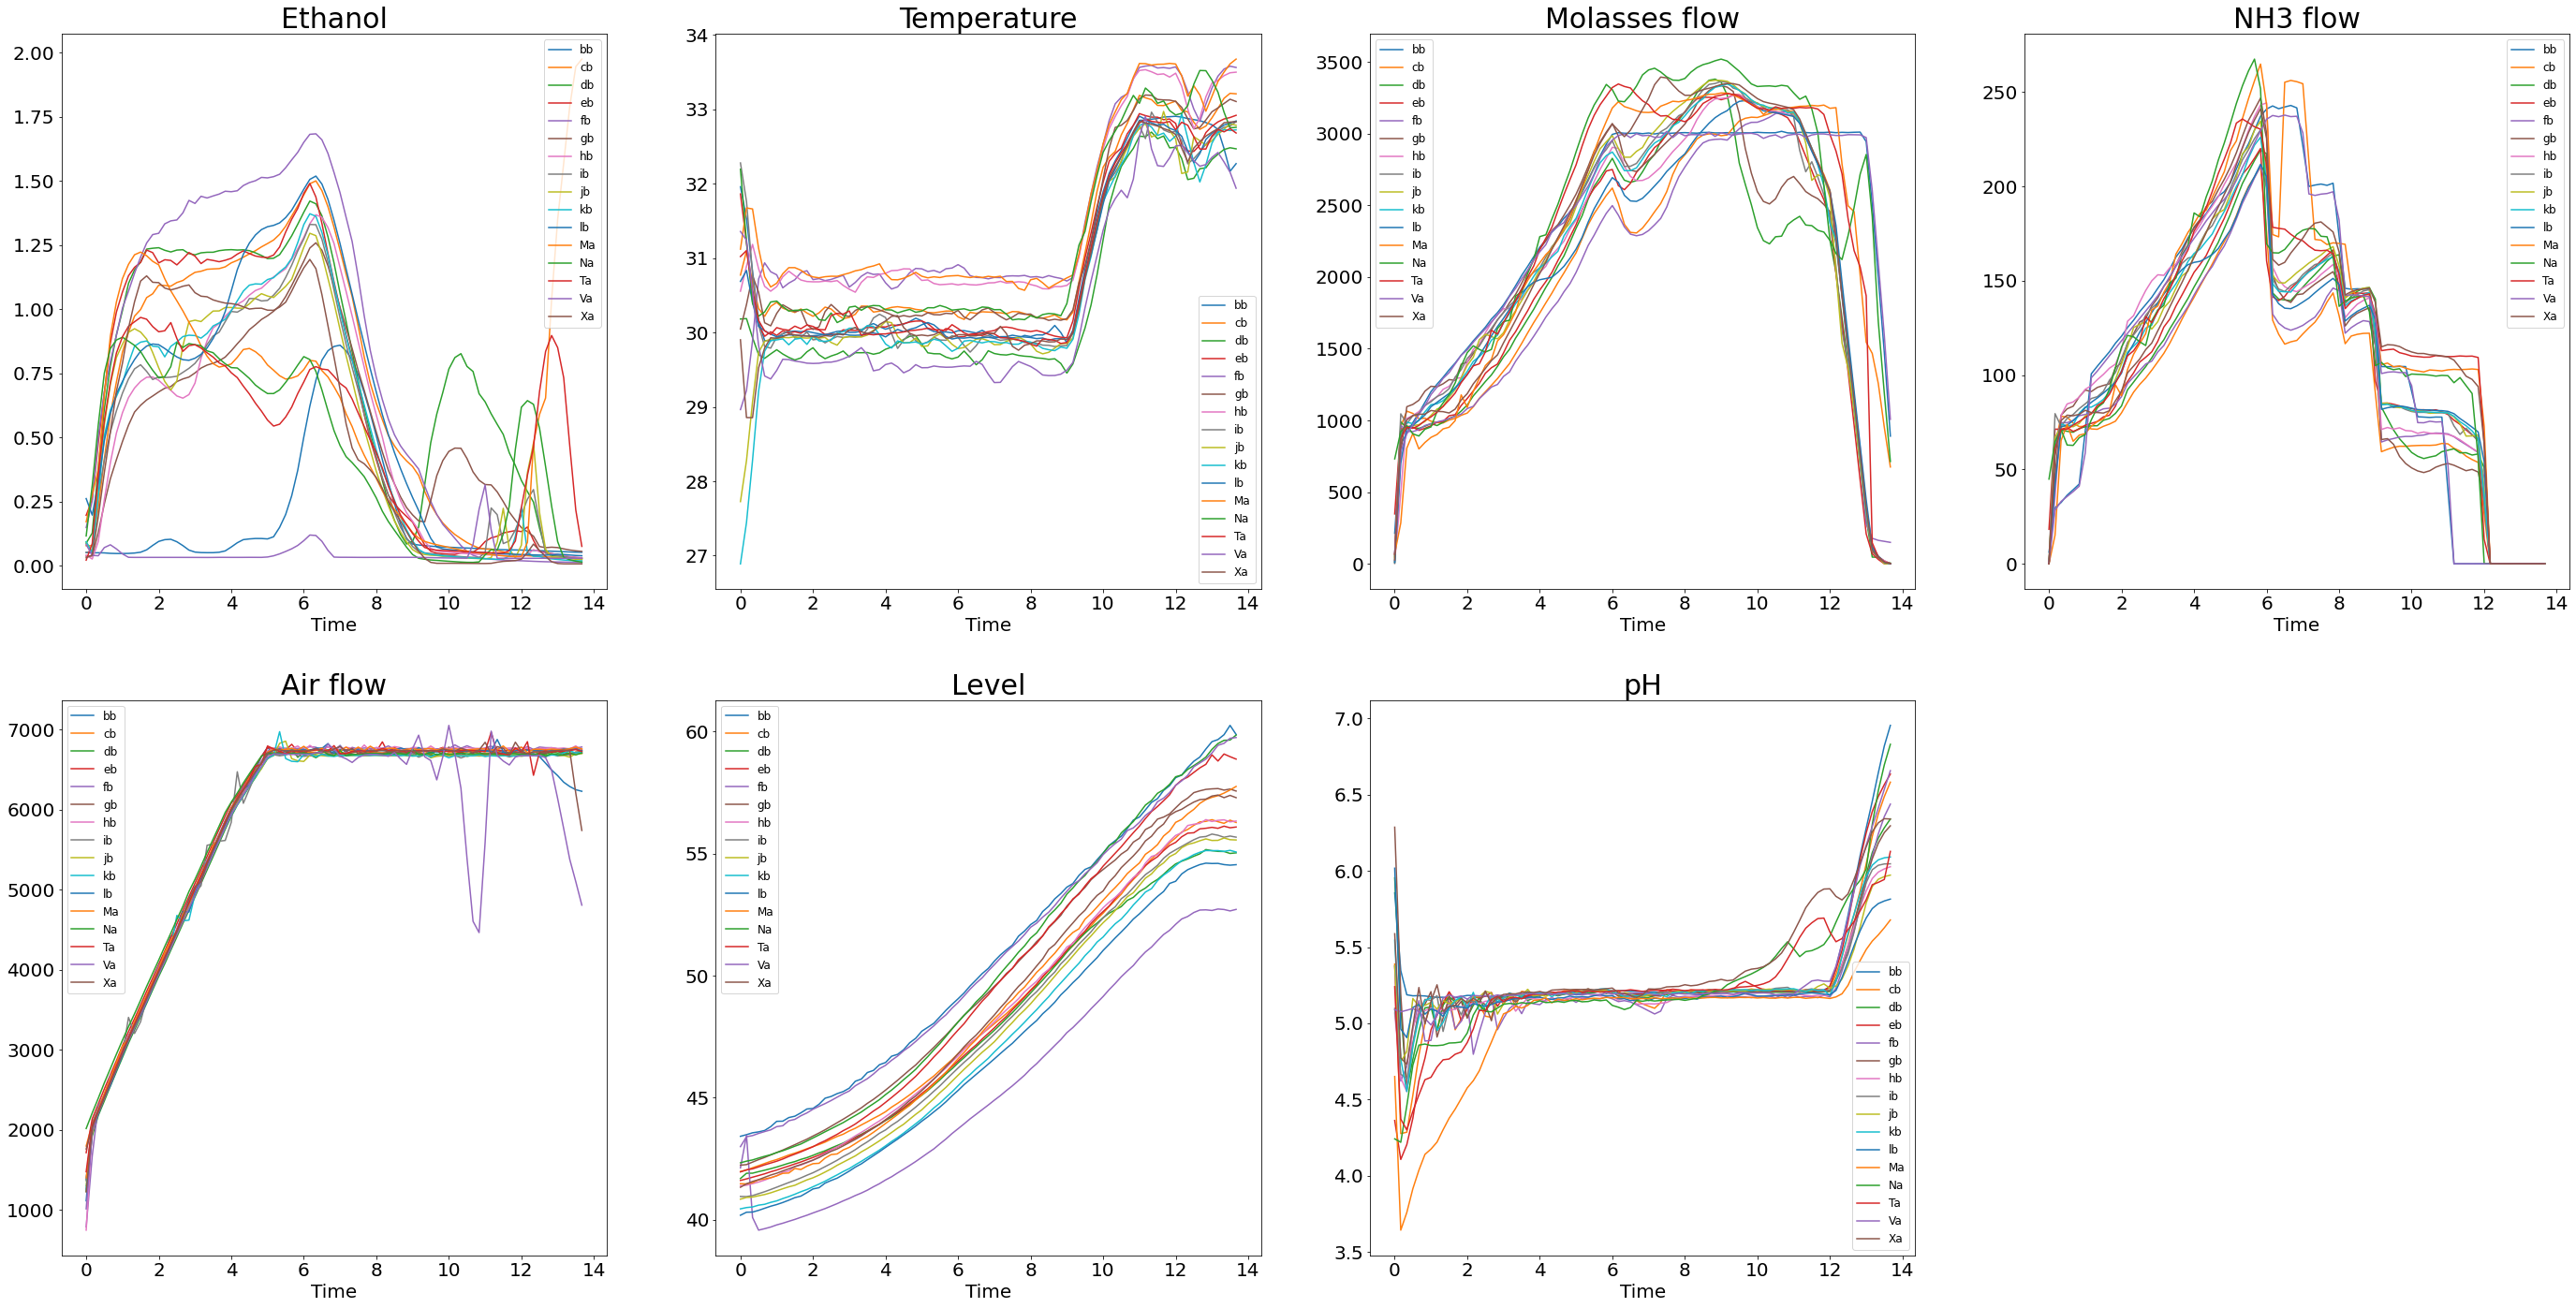

In [7]:
plt.figure(figsize=(48,24))
cols = bakers.columns[1:]

for i in range(len(cols)):
  plt.subplot(2,4,i+1)
  for batch in bakers.index.unique():
    temp = bakers[bakers.index==batch]
    plt.plot(temp['Time'],temp[cols[i]],label=batch)
    plt.title(cols[i],fontsize=30)
    plt.xticks(fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=12)

> 3. Select the features (including the Time column), pre-process the data and perform PCA with 5 principal components. Extract the scores and loadings.

In [4]:
#scale the data
scaler = StandardScaler()
bakers_scaled = scaler.fit_transform(bakers)

In [5]:
#perform PCA with 5PCs
pca = PCA(n_components=5, svd_solver='full')
pca_scores = pca.fit_transform(bakers_scaled)
# Extract the scores
scores_pd = pd.DataFrame(data = pca_scores, columns = ['PC1', 'PC2', 'PC3','PC4','PC5'], index = bakers.index)
# Extract the loadings
loadings_pd = pd.DataFrame(data = pca.components_.T, columns = ['PC1', 'PC2', 'PC3','PC4','PC5'], index = bakers.columns)

> 4. In order to plot the scores-loading plot, you need to pivot the scores BatchID with index 'Time' (use pandas pivot table).

In [6]:
#add column "Time"
scores_pd['Time'] = bakers['Time']
#pivot the scores BatchID with index 'Time'
scores_pivot = pd.pivot_table(scores_pd,values=['PC1', 'PC2', 'PC3','PC4','PC5'],index='Time',columns='BatchID')
scores_pivot

PC1                      ...       PC5                    
BatchID          Ma        Na        Ta  ...        jb        kb        lb
Time                                     ...                              
0.000000  -2.575226 -2.494768 -1.834810  ...  1.438659  1.833015 -0.111854
0.166667  -3.406333 -2.944182 -2.731785  ...  0.774914  1.236314 -0.332924
0.333333  -3.390333 -3.070940 -3.117042  ...  0.456887  0.850361 -0.270976
0.500000  -3.534499 -2.888284 -3.194946  ...  0.199308  0.471139 -0.038183
0.666667  -3.596972 -2.732277 -3.165646  ...  0.218693  0.224946  0.038438
...             ...       ...       ...  ...       ...       ...       ...
13.000000  2.489762  4.277071  3.184812  ... -0.126855 -0.147775 -0.175886
13.166700  2.481818  4.552587  3.157697  ... -0.242682 -0.292980 -0.289735
13.333300  2.421492  4.641010  3.372776  ... -0.286531 -0.326307 -0.334636
13.500000  2.397535  4.702980  3.579729  ... -0.338967 -0.322784 -0.355440
13.666700  2.442108  4.826890  3.850841  ... -0.322251 -0.327004 -0.367125

[83 rows x 80 columns]

> 5. Plot the scores-loadings plot with one line per batch (this is why the pivot in the previous step was needed). The output should look similar to the plot below. You may choose a different scaling, but the trend should be the same as this graph.

In [52]:
def myplot(batches,scores,loadings,loading_labels=None,score_labels=None):
  for i in batches:
    # adjusting the scores to fit in (-1,1)
    xt = scores['PC1'][i]
    yt = scores['PC2'][i]

    scalext = 1.0/(xt.max() - xt.min())
    scaleyt = 1.0/(yt.max() - yt.min())
    xt_scaled = xt * scalext
    yt_scaled = yt * scaleyt

    plt.plot(xt_scaled, yt_scaled)

  # adjusting the loadings to fit in (-1,1)
  p = loadings
  p_scaled = MaxAbsScaler().fit_transform(p)
  n = loadings.shape[0]
  
  for i in range(n):
    plt.arrow(0, 0, p_scaled[i,0], p_scaled[i,1], color = 'r',alpha = 0.5)
    plt.text(p_scaled[i,0], p_scaled[i,1], loading_labels[i], color = 'r', ha = 'center', va = 'center', size=15)

  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.xlabel("PC{}".format(1), fontsize=15);
  plt.ylabel("PC{}".format(2), fontsize=15);
  plt.tick_params(labelsize=12)
  #x-axis, y-axis
  plt.axvline(0,color='black')
  plt.axhline(0,color='black')
  plt.grid()

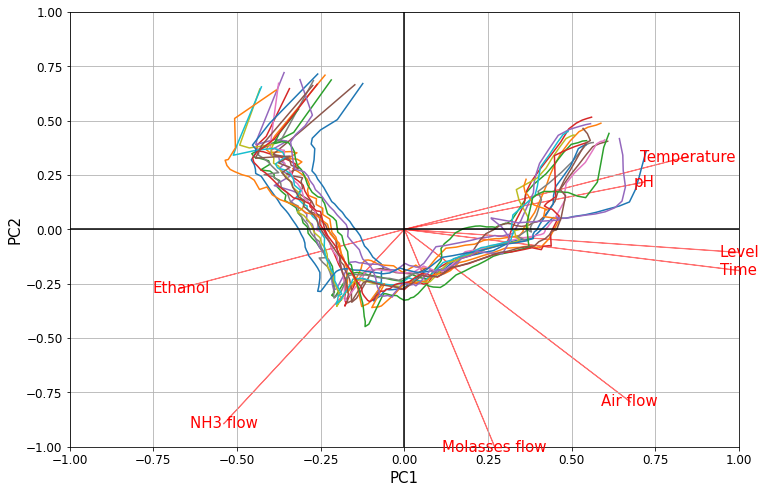

In [53]:
plt.rcParams["figure.figsize"] = [12,8]
myplot(bakers.index.unique(),scores_pivot,loadings_pd.iloc[:,:2],loading_labels=loadings_pd.index,score_labels=scores_pd.index)
plt.show()

> 6. Explain this graph. In which quarter do the batches start and end? What happens at the kink where the direction of the lines changes? Can you tell from this graph which variables do not change in the first phase and which in the second phase?

The batches start from quarter four and end in quarter one. The kink happened where some drastic change in some variables while other variables remain stable. In the first phase 'Molasses flow' and 'Air flow' do not change. In the second phase, 'Temperature', 'PH' and 'Ethanol' do not change.


> 7. Plot the cumulative explained variance. How much variance do the first two principal components capture?

The first 2 components describe 78.46737653782884 percent of the variance

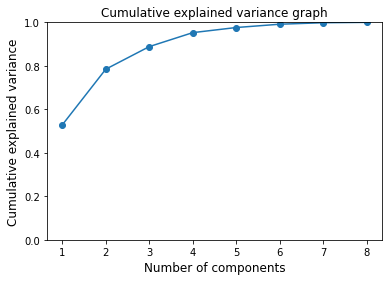

In [7]:
#plot the cumulative explained variance graph
pca_all = PCA(n_components=8, svd_solver='full')
pca_all.fit(bakers_scaled)
plt.plot(range(1,pca_all.n_components+1), np.cumsum(pca_all.explained_variance_ratio_),'-o')
plt.xlabel('Number of components', fontsize=12)
plt.ylabel('Cumulative explained variance', fontsize=12)
plt.title('Cumulative explained variance graph')
plt.tick_params(labelsize=10)
plt.ylim(0,1)
plt.show()

In [8]:
#percent of the variance
print(f"The first 2 components describe {sum(pca_all.explained_variance_ratio_[:2])*100} percent of the variance")

The first 2 components describe 78.46737653782884 percent of the variance


##2.2 Use the model to monitor running batches
>The goal of building an unsupervised model is to monitor the running batches. Your site runs two reactors in parallel and here you will fit the data from these two reactors to the model previously built and identify potential problems and outliers.


> 1. Load the data from the file 'todays batches.xlsx' and repeat the same procedure as in the steps 3-4 of the previous section with the exception of the PCA modeling. Here, instead of fit the data to the model and transform, you will only transform them with the model object you created in the previous section.

> 2. Plot the same scores-loadings plot for the data in the batches you used to develop the model with solid lines. Overlay the new incoming data from the two current batches with dashed lines and two different colours to distinguish them. Also, add a legend for the two batches so that the viewer can distinguish them.

> 3. Do the batches show behaviour similar to that of the reference ones or there are outliers indicating potential problems?